In [1]:
from __future__ import print_function
import torch.nn as nn
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage import io, transform
import utils_xy
from torchvision import transforms, utils
import torch
import torch.nn.functional as F
import numpy as np

### Set uo the visible GPU

In [2]:
gpu_id = 1
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

device = torch.device('cuda')
print (device)

cuda


### Load the datasets

In [3]:
# load the training images and the semantic segmentation image (mask image)
train = '/home/xiaoyu/data_semantics/training/train/image/'
train_mask = '/home/xiaoyu/data_semantics/training/train/mask_rgb/'

trainimage = os.listdir(train)
trainmask = os.listdir(train_mask)

print("Training images numbers for different folder of training images: "+str(len(trainimage)))
print("Training mask Images numbers:"+str(len(trainmask)))
image_ex = trainimage[1]
print(image_ex)

Training images numbers for different folder of training images: 160
Training mask Images numbers:160
000102_10.png


In [4]:
# image size
print("The mask image size is:" + str(io.imread(os.path.join(
    train_mask, image_ex)).shape))
print("The training image size is:" + str(io.imread(os.path.join(
    train, image_ex)).shape
))

The mask image size is:(375, 1242, 3)
The training image size is:(375, 1242, 3)


### Observe the train data

In [5]:
print(io.imread(os.path.join(train, image_ex)).dtype)

uint8


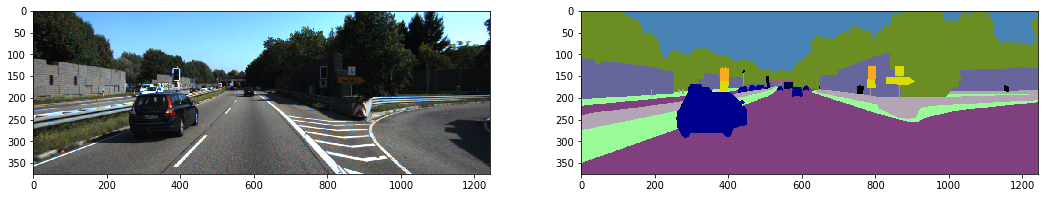

In [6]:
def show_semantic(image, semantic):
    """
    Show images with semantic segmentation
    Args:
        image(numpyarray): The training image
        semantic(numpyarray): The traing image semantic segmentation
    """
    
    
#     plt.figure(figsize=(18, 3))
    plt.subplot(1,2,1)
    plt.imshow(image, aspect='auto')
    plt.subplot(1,2,2)
    plt.imshow(semantic, aspect='auto')
    plt.show()
    
# test the function
plt.figure(figsize=(18, 3))
show_semantic(io.imread(os.path.join(train,image_ex)), 
              io.imread(os.path.join(train_mask,image_ex)))

## Preprocessing of the images
### Define the traindataset class

In [7]:
class TrainDataset(Dataset):
    """Training dataset with mask image on gray scale/RGB"""
    def __init__(self, train_dir, semantic_dir, transform=None):
        """
        Args:
            train_dir (string): Directory with training images
            transform (callable): Optional transform to be applied on a sample
            semantic_dir (string): Directory with semantic segmentation training image
        """
        self.train_dir = train_dir
        self.transform = transform
        self.semantic_dir = semantic_dir
        
    def __len__(self):
        return len(os.listdir(self.train_dir))
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.train_dir, os.listdir(self.train_dir)[idx])
        semantic_name = os.path.join(self.semantic_dir, os.listdir(self.semantic_dir)[idx])
        image = io.imread(img_name)
        semantic = io.imread(semantic_name)
        sample = {'image':image, 'semantic':semantic}
        
        if self.transform:
            sample = self.transform(sample)
        return sample

0 (375, 1242, 3) (375, 1242, 3)


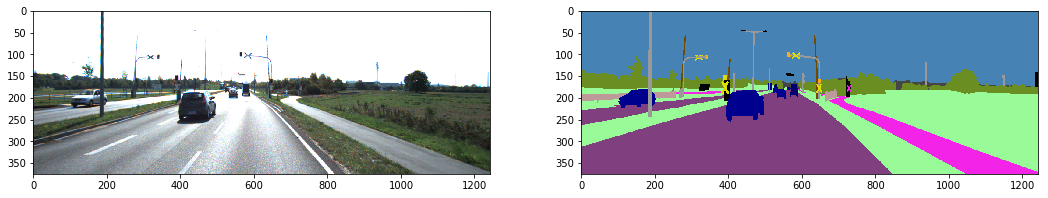

1 (375, 1242, 3) (375, 1242, 3)


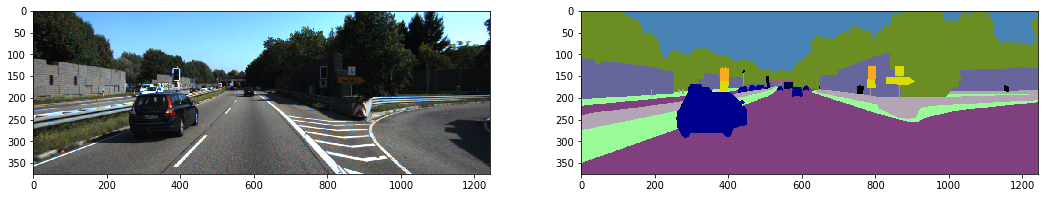

2 (375, 1242, 3) (375, 1242, 3)


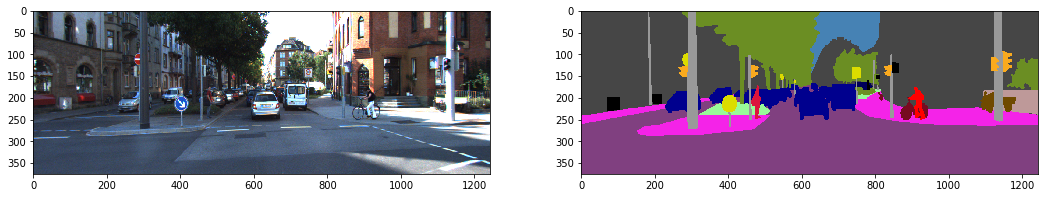

In [8]:
# test the traindataset class without data preprocessing
train_data = TrainDataset(train_dir=train, semantic_dir =train_mask)

for i in range(len(train_data)):
    sample = train_data[i]
    print(i, sample['image'].shape, sample['semantic'].shape)
    plt.figure(figsize=(18, 3))
    show_semantic(sample['image'],sample['semantic'])
    
    if i == 2:  
        break

In [9]:
class ToTensor(object):
    """Convert ndarrays in sample (both the original image 
    and the semantic image to Tensors"""
    
    def __call__(self, sample):
        image, semantic = sample['image'],sample['semantic']
        
        #swap color axis because
        #numpy image: H x W x C
        #torch image: C x H x W
        image = image.transpose((2, 0, 1))
        semantic = semantic.transpose((2,0,1))
        return {'image': torch.from_numpy(image),
                'semantic': torch.from_numpy(semantic)}

In [10]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, semantic = sample['image'], sample['semantic']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        semantic = transform.resize(semantic, (new_h, new_w))

        return {'image': img, 'semantic': semantic}
   

In [11]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, semantic = sample['image'],sample['semantic']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h-new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h, left: left + new_w]

        semantic = semantic[top: top + new_h, left: left + new_w]

        return {'image': image, 'semantic': semantic}

The original image:


<Figure size 432x288 with 0 Axes>

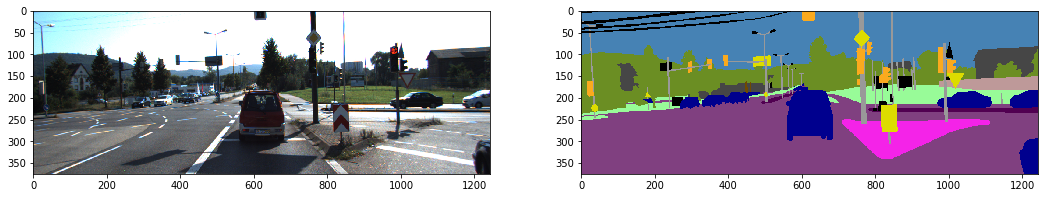

The cropped image:


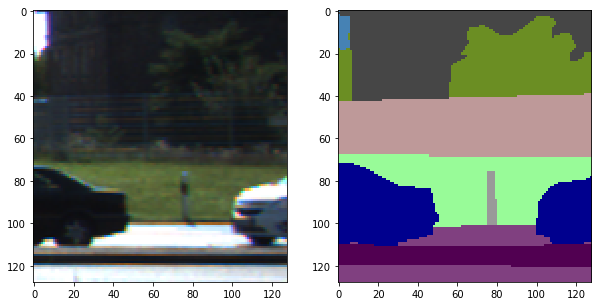

The rescaled image:


/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


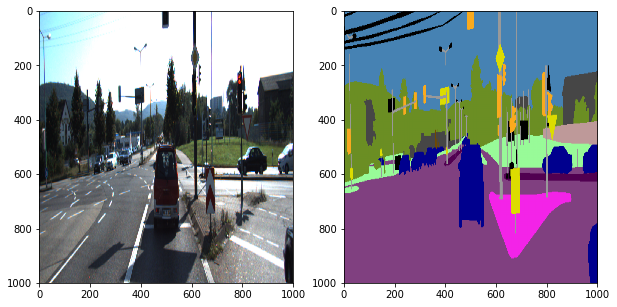

The composed transformed image:


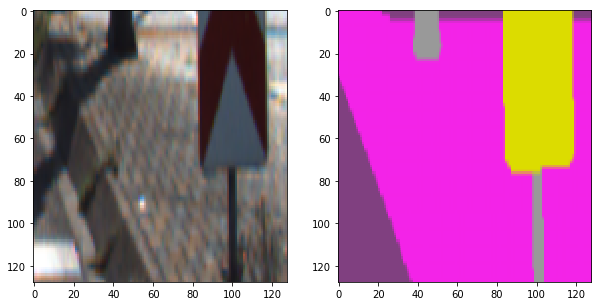

In [12]:
# test of the tress preprocessing of the image functions
scale = Rescale((1000,1000))
crop = RandomCrop(128)
composed = transforms.Compose([Rescale((1000,1000)),RandomCrop(128)])

fig = plt.figure()
sample = train_data[30]

print("The original image:")
plt.figure(figsize=(18, 3))
show_semantic(**sample)

print("The cropped image:")
croped_sample = crop(sample)
plt.figure(figsize=(10, 5))
show_semantic(**croped_sample)

print("The rescaled image:")
rescaled_sample = scale(sample)
plt.figure(figsize=(10,5))
show_semantic(**rescaled_sample)

print("The composed transformed image:")
composed_sample = composed(sample)
plt.figure(figsize=(10, 5))
show_semantic(**composed_sample)

### Make several transformed datasets, which are subsets of the datasets

In [13]:
composed = transforms.Compose([RandomCrop(128), ToTensor()])
transformed_dataset_A = TrainDataset(train_dir=train, semantic_dir =train_mask, transform = composed)
transformed_dataset_B = TrainDataset(train_dir=train, semantic_dir =train_mask, transform = composed) 

In [18]:
# Test the transformed dataset, visualize of the size of the transformed dataset.
for i in range(len(transformed_dataset_A)):
    sample = transformed_dataset_A[i]
    
    print(i, sample['image'].type(torch.FloatTensor).dtype, sample['semantic'].dtype)
    
    if i == 3:
        break

print("Transformed_dataset is : " + str(type(transformed_dataset_A)))

0 torch.float32 torch.uint8
1 torch.float32 torch.uint8
2 torch.float32 torch.uint8
3 torch.float32 torch.uint8
Transformed_dataset is : <class '__main__.TrainDataset'>


### Dataloader class is used for: 
* Batching the data
* Shuffling the data
* Load the data in parallel using multiprocessing workers.
* ```torch.utils.data.DataLoader``` is an iterator which provides all these features. Parameters used below should be clear. One parameter of interest is collate_fn. You can specify how exactly the samples need to be batched using collate_fn. However, default collate should work fine for most use cases.

In [20]:
dataloader = DataLoader(transformed_dataset_A, batch_size=1, shuffle = False, num_workers = 4)

### Make a dataloader of two different transformed dataset

In [38]:
train_loader = DataLoader(transformed_dataset_A+transformed_dataset_B,
                          batch_size=1, shuffle=False,
                          num_workers=4)

In [44]:
print(len(train_loader))

for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch)
    print(sample_batched['image'].size())
    if i_batch ==0:
        break

320
0
torch.Size([1, 3, 128, 128])


In [45]:
# Helper function to show a batch
def show_semantic_batch(sample_batched):
    """Show original images and semantic images for a batch of samples"""
    images_batch, semantic_batch = \
            sample_batched['image'], sample_batched['semantic']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    
    grid = utils.make_grid(images_batch)
    grid_semantic = utils.make_grid(semantic_batch)
    plt.imshow(grid.numpy().transpose((1,2,0)))
    plt.pause(0.5)
    plt.imshow(grid_semantic.numpy().transpose((1,2,0)))
 

0 torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 128])
torch.uint8
1 torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 128])
torch.uint8
2 torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 128])
torch.uint8
3 torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 128])
torch.uint8


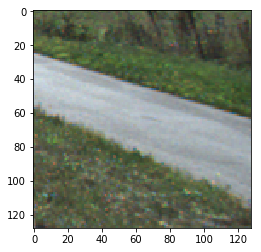

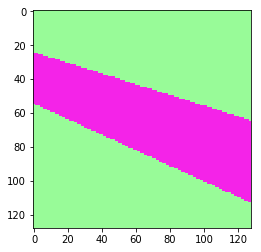

In [47]:
for i_batch, (inputs, target) in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(), sample_batched['semantic'].size())
    print(sample_batched['image'].dtype)
    #Observe the 4th batch and stop
    if i_batch == 3:
        plt.figure()
        show_semantic_batch(sample_batched)
        break

### Define the Unet

In [48]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2
    Args:
        in_ch: number of channels of the input
        out_ch: number of channels of the output
        inputsize (N, C_in, H, W) 
        outputsize (N, C_out, H_out, W_out)
        where N is the batch size, C is the number of channels
        kernel =3, stride =1, padding =0
        after the double_conv, the image size is decreased by 4 on each dimention
    '''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),  
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        
        x = self.conv(x)    
        return x

double_conv(
  (conv): Sequential(
    (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
  )
)
torch.Size([3, 3])
The first conv's weight is: torch.Size([1, 1, 3, 3])
The output size is: torch.Size([2, 1, 572, 572])


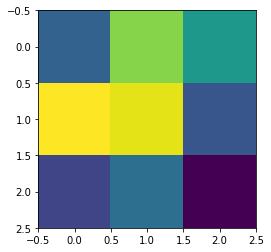

In [49]:
# test the double_conv
double_convnet = double_conv(1,1)
print(double_convnet)
input = torch.randn(2,1,572,572)
output = double_convnet(input)
double_convparams = list(double_convnet.parameters())
first_w = double_convparams[0].detach().squeeze()
print(first_w.size())
plt.imshow(first_w)
print("The first conv's weight is: "+str(double_convparams[0].size()))
print("The output size is: "+str(output.size()))

In [50]:
class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

In [51]:
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

In [52]:
class up(nn.Module):
    """The algorithms available for upsampling are nearest neighbor and linear,
    bilinear and trilinear for 3D, 4D and 5D input Tensor, respectively."""
    
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
            #Applies a 2D transposed convolution operator over an input image
            #composed of several input planes, sometimes also called “deconvolution”.

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


In [53]:
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [54]:
class UNet(nn.Module):
    """
    Args:
        input channel(int)
        output channel(int)
    """
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

#### Unet parameters

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-0

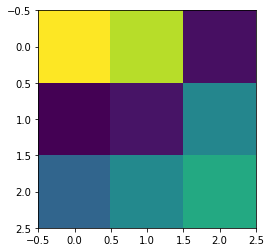

torch.Size([3, 3])


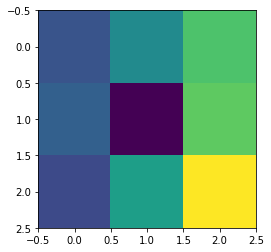

torch.Size([3, 3])


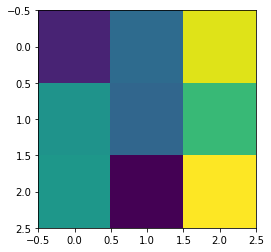

In [55]:
unet = UNet(3,3)
print(unet)
unet_params = list(unet.parameters())
print("The length of the unet parameter is: ")
print(len(unet_params))
print("The conv1's weight: ")
print(unet_params[0].size()) # conv1's weight  0.4.
print("The weight's dtype: ")
print(unet_params[0].dtype)

#visualization of the weight
for m in range(64):
    for n in range(3):
        first_weight = unet_params[0].detach().squeeze()[m,n,:,:]
        print(first_weight.size())
        plt.imshow(first_weight)
        plt.pause(1)
    if m ==0:
        break


### Send the weights of the networks to the GPU 

In [56]:
current_device = torch.cuda.current_device()
torch.cuda.device(current_device)

In [57]:
torch.cuda.device_count()

1

In [58]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

In [59]:
unet = unet.to(device)

In [60]:
print(unet_params[0].dtype)

torch.float32


### Test the network

In [61]:
inputs = torch.randn(1, 3, 128, 128).to(device)
print(inputs.dtype)
outputs = unet(inputs)
print(outputs.shape)
print(outputs.dtype)
print(outputs)

torch.float32
torch.Size([1, 3, 128, 128])
torch.float32
tensor([[[[0.5340, 0.4870, 0.5151,  ..., 0.5432, 0.4611, 0.5132],
          [0.4556, 0.4550, 0.4980,  ..., 0.4843, 0.5251, 0.4674],
          [0.3955, 0.4854, 0.5131,  ..., 0.5454, 0.5303, 0.4728],
          ...,
          [0.5039, 0.4185, 0.4482,  ..., 0.5153, 0.4057, 0.4981],
          [0.5144, 0.4007, 0.4742,  ..., 0.4374, 0.5217, 0.4997],
          [0.5154, 0.5372, 0.4222,  ..., 0.5337, 0.4632, 0.5091]],

         [[0.4810, 0.5094, 0.4600,  ..., 0.4598, 0.4815, 0.4575],
          [0.4776, 0.4836, 0.4618,  ..., 0.5448, 0.4958, 0.4968],
          [0.4288, 0.5447, 0.3930,  ..., 0.5415, 0.4621, 0.4941],
          ...,
          [0.5320, 0.4957, 0.4259,  ..., 0.5041, 0.5521, 0.4680],
          [0.4817, 0.4421, 0.5171,  ..., 0.5064, 0.5609, 0.4345],
          [0.4965, 0.5166, 0.5244,  ..., 0.5380, 0.5166, 0.4721]],

         [[0.4710, 0.5013, 0.5340,  ..., 0.4694, 0.4941, 0.5549],
          [0.5532, 0.4793, 0.5884,  ..., 0.4930, 0.

/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


### Visualization before training

The inputs is: 
tensor([[[[ 94.,  94.,  96.,  ...,  90.,  91.,  90.],
          [ 86.,  84.,  80.,  ...,  89.,  92.,  82.],
          [ 91.,  94.,  98.,  ...,  85.,  85.,  84.],
          ...,
          [117., 120.,  69.,  ...,  49.,  46.,  56.],
          [116.,  96.,  58.,  ...,  68.,  68.,  67.],
          [120.,  91.,  56.,  ...,  75.,  80.,  74.]],

         [[106., 110., 108.,  ..., 114., 107., 115.],
          [ 98.,  96.,  93.,  ..., 106., 103., 106.],
          [112., 101., 108.,  ..., 102.,  98.,  99.],
          ...,
          [115.,  88.,  70.,  ...,  52.,  56.,  55.],
          [103.,  83.,  60.,  ...,  62.,  72.,  74.],
          [127.,  81.,  59.,  ...,  83.,  91.,  88.]],

         [[ 79.,  70.,  80.,  ...,  67.,  79.,  79.],
          [ 71.,  68.,  76.,  ...,  74.,  79.,  79.],
          [ 61.,  62.,  71.,  ...,  81.,  81.,  81.],
          ...,
          [102.,  71.,  57.,  ...,  40.,  46.,  48.],
          [103.,  74.,  54.,  ...,  32.,  42.,  49.],
          [118., 

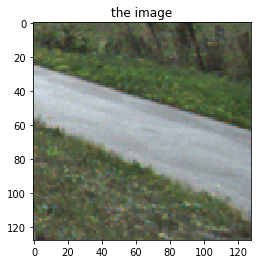

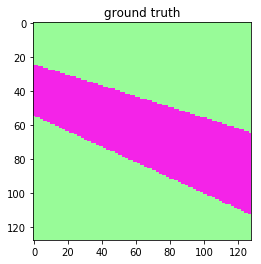

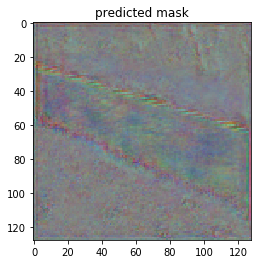

In [62]:
for i_batch, sample_batched in enumerate(train_loader):
    
    # Prepare the data
    inputs, labels = sample_batched['image'], sample_batched['semantic']
    inputs_float = inputs.type(torch.FloatTensor)
    labels_float = labels.type(torch.FloatTensor)/255
    
    print("The inputs is: ")
    print(inputs_float)
    
    print('\n The groundtruth label is: ')
    print(labels_float)
   
    outputs = unet(inputs_float.cuda())
    print("\n The output is: ")
    print(outputs.dtype)
    print(outputs)
    
    print("The image size is: "+ str(inputs_float.size()) + ". The inputs data type is: " + str(inputs_float.dtype))
    print("The groundtruth mask size is :"+ str(labels.size()) + ". The groundtruth mask type is: " + str(labels_float.dtype))
    print("The predicted mask size is :" +str(outputs.size()) + ". The predicted mask type is " + str(outputs.dtype))
    
    
    #Visualisaton
    image_in = inputs_float.detach().squeeze().permute(1,2,0)
    image_mask = labels_float.detach().squeeze().permute(1,2,0)
    image_out = outputs.detach().squeeze().permute(1,2,0)
    
#
    plt.imshow(image_in.type(torch.ByteTensor))
    plt.title("the image")
    plt.pause(1)
    
    plt.imshow(image_mask)
    plt.title("ground truth")
    plt.pause(1)
    
    plt.imshow(image_out)
    plt.title("predicted mask")
    plt.pause(1)
    
    if i_batch == 0:
        
        break

### Define a Loss function and optimizer

In [63]:
import torch.optim as optim
optimizer = optim.SGD(unet.parameters(),
                      lr=0.001,
                      momentum=0.9,
                      weight_decay=0.0005)
    
criterion = nn.BCELoss()

### Train the network

In [64]:
for epoch in range(100):
    # loop over the dataset 1 times
    running_loss = 0.0
    for i_batch, sample_batched in enumerate(train_loader):
        
        #get the inputs
        inputs, labels = sample_batched['image'], sample_batched['semantic']
        inputs_float = inputs.type(torch.FloatTensor)
        labels_float = labels.type(torch.FloatTensor)/255
    
#         print("The inputs is: ")
#         print(inputs_float)
    
#         print('\n The groundtruth label is: ')
#         print(labels_float)
        
        #zero the parameter gradients
        optimizer.zero_grad()
        
        #forward + backward +optimize
        outputs = unet(inputs_float.cuda())
#         print("\n The output is: ")
#         print(outputs.dtype)
#         print(outputs)
    
#         print("The image size is: "+ str(inputs_float.size()) + ". The inputs data type is: " + str(inputs_float.dtype))
#         print("The groundtruth mask size is :"+ str(labels.size()) + ". The groundtruth mask type is: " + str(labels_float.dtype))
#         print("The predicted mask size is :" +str(outputs.size()) + ". The predicted mask type is " + str(outputs.dtype))
           
        # Define the loss
        loss = criterion(outputs, labels_float.cuda())      
        loss.backward()
        optimizer.step()
#         if i_batch ==3:
#             break
        
        #print statistics
        running_loss += loss.item()
        if i_batch%160 == 159: 
            # print every 20 mini-batchs
            print('[%d, %5f] loss: %.3f'%(epoch +1, i_batch+1, running_loss/160))
            running_loss = 0.0
print('Finish Training')

[1, 160.000000] loss: 0.688
[1, 320.000000] loss: 0.677
[2, 160.000000] loss: 0.674
[2, 320.000000] loss: 0.669
[3, 160.000000] loss: 0.670
[3, 320.000000] loss: 0.666
[4, 160.000000] loss: 0.668
[4, 320.000000] loss: 0.663
[5, 160.000000] loss: 0.665
[5, 320.000000] loss: 0.660
[6, 160.000000] loss: 0.662
[6, 320.000000] loss: 0.657
[7, 160.000000] loss: 0.658
[7, 320.000000] loss: 0.653
[8, 160.000000] loss: 0.655
[8, 320.000000] loss: 0.649
[9, 160.000000] loss: 0.652
[9, 320.000000] loss: 0.647
[10, 160.000000] loss: 0.650
[10, 320.000000] loss: 0.645
[11, 160.000000] loss: 0.648
[11, 320.000000] loss: 0.643
[12, 160.000000] loss: 0.646
[12, 320.000000] loss: 0.640
[13, 160.000000] loss: 0.644
[13, 320.000000] loss: 0.639
[14, 160.000000] loss: 0.642
[14, 320.000000] loss: 0.636
[15, 160.000000] loss: 0.640
[15, 320.000000] loss: 0.635
[16, 160.000000] loss: 0.638
[16, 320.000000] loss: 0.633
[17, 160.000000] loss: 0.637
[17, 320.000000] loss: 0.631
[18, 160.000000] loss: 0.635
[18

Process Process-341:
Process Process-344:
Process Process-343:
Process Process-342:


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (mos

### Visualization after training

The inputs is: 
tensor([[[[ 94.,  94.,  96.,  ...,  90.,  91.,  90.],
          [ 86.,  84.,  80.,  ...,  89.,  92.,  82.],
          [ 91.,  94.,  98.,  ...,  85.,  85.,  84.],
          ...,
          [117., 120.,  69.,  ...,  49.,  46.,  56.],
          [116.,  96.,  58.,  ...,  68.,  68.,  67.],
          [120.,  91.,  56.,  ...,  75.,  80.,  74.]],

         [[106., 110., 108.,  ..., 114., 107., 115.],
          [ 98.,  96.,  93.,  ..., 106., 103., 106.],
          [112., 101., 108.,  ..., 102.,  98.,  99.],
          ...,
          [115.,  88.,  70.,  ...,  52.,  56.,  55.],
          [103.,  83.,  60.,  ...,  62.,  72.,  74.],
          [127.,  81.,  59.,  ...,  83.,  91.,  88.]],

         [[ 79.,  70.,  80.,  ...,  67.,  79.,  79.],
          [ 71.,  68.,  76.,  ...,  74.,  79.,  79.],
          [ 61.,  62.,  71.,  ...,  81.,  81.,  81.],
          ...,
          [102.,  71.,  57.,  ...,  40.,  46.,  48.],
          [103.,  74.,  54.,  ...,  32.,  42.,  49.],
          [118., 

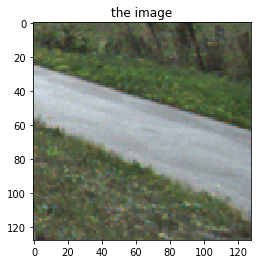

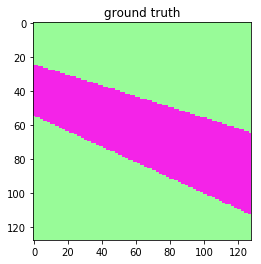

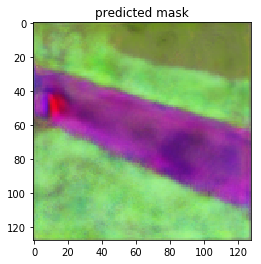

In [66]:
for i_batch, sample_batched in enumerate(train_loader):
    
    # Prepare the data
    inputs, labels = sample_batched['image'], sample_batched['semantic']
    inputs_float = inputs.type(torch.FloatTensor)
    labels_float = labels.type(torch.FloatTensor)/255
    
    print("The inputs is: ")
    print(inputs_float)
    
    print('\n The groundtruth label is: ')
    print(labels_float)
   
    outputs = unet(inputs_float.cuda())
    print("\n The output is: ")
    print(outputs.dtype)
    print(outputs)
    
    print("The image size is: "+ str(inputs_float.size()) + ". The inputs data type is: " + str(inputs_float.dtype))
    print("The groundtruth mask size is :"+ str(labels.size()) + ". The groundtruth mask type is: " + str(labels_float.dtype))
    print("The predicted mask size is :" +str(outputs.size()) + ". The predicted mask type is " + str(outputs.dtype))
    
    
    #Visualisaton
    image_in = inputs_float.detach().squeeze().permute(1,2,0)
    image_mask = labels_float.detach().squeeze().permute(1,2,0)
    image_out = outputs.detach().squeeze().permute(1,2,0)
    
#
    plt.imshow(image_in.type(torch.ByteTensor))
    plt.title("the image")
    plt.pause(1)
    
    plt.imshow(image_mask)
    plt.title("ground truth")
    plt.pause(1)
    
    plt.imshow(image_out)
    plt.title("predicted mask")
    plt.pause(1)
    
    if i_batch == 0:
        
        break
    

### Try another sub-dataset, since the transformed dataset used above is only a subset of the original dataset